In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
from keras.layers import Input, Reshape, Dropout, Dense 
from keras.layers import Flatten, BatchNormalization
from keras.layers import Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

In [ ]:
GENERATE_RES = 1 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 3
PREVIEW_COLS = 3
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/Computer_Vision/0009-plan_diagram28/color-28'
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 32px square images.


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)


Looking for file: /content/drive/MyDrive/Computer_Vision/0009-plan_diagram28/color-28/training_data_32_32.npy
Loading previous training pickle...


In [ ]:
#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **build generator**

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

## **build_discriminator**

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))
#1
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
#2
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
#3
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
#4
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
#5
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator([4,100,3])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 2, 50, 32)         896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 50, 32)         0         
                                                                 
 dropout (Dropout)           (None, 2, 50, 32)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 25, 64)         18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 26, 64)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 2, 26, 64)        256       
 hNormalization)                                      

## **save image**

tf.Tensor([[0.4998603]], shape=(1, 1), dtype=float32)


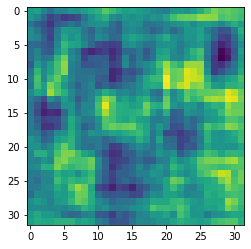

In [ ]:
def save_images(cnt,noise):
  output_folder = '/content/drive/MyDrive/Computer_Vision/0009-plan_diagram28'
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(output_folder,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

## **train**

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()
  g_loss = []
  d_loss = []
  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
    tempg = sum(gen_loss_list) / len(gen_loss_list)
    tempd = sum(disc_loss_list) / len(disc_loss_list)
    g_loss.append(tempg)
    d_loss.append(tempd)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={tempg},disc loss={tempd},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

  return {"d_loss":d_loss, "g_loss":g_loss}


In [ ]:
EPOCHS = 10
hist = train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.5965895652770996,disc loss=0.4466117024421692, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 565ms/step
Epoch 2, gen loss=3.066251277923584,disc loss=0.6294897794723511, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 336ms/step
Epoch 3, gen loss=2.9207379817962646,disc loss=0.7432780265808105, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 218ms/step
Epoch 4, gen loss=2.763000249862671,disc loss=0.8555033206939697, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 186ms/step
Epoch 5, gen loss=2.7429754734039307,disc loss=0.7990785241127014, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 204ms/step
Epoch 6, gen loss=2.664353370666504,disc loss=0.9770101308822632, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 204ms/step
Epoch 7, gen loss=2.644178628921509,disc loss=0.7823154330253601, {hms_string(epoch_elapsed)}
1/1 [================

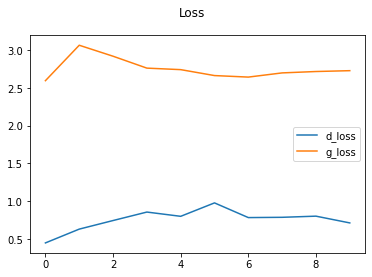

In [ ]:
plt.suptitle('Loss')
plt.plot(hist['d_loss'], label='d_loss')
plt.plot(hist['g_loss'], label='g_loss')
plt.legend()
plt.show()

## **save model**

In [ ]:
output_folder ='/content/drive/MyDrive/Computer_Vision/0009-plan_diagram28' 
save_model_path = os.path.join(output_folder,'model')
if not os.path.exists(save_model_path):
  os.makedirs(save_model_path)

In [ ]:
generator.save(save_model_path,'generator.h5')
discriminator.save(save_model_path,'discriminator.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Computer_Vision/0009-plan_diagram28/model')

In [ ]:
def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(INPUT_SIZE,))
    generator_output = generator(gan_input)
    gan_output = discriminator(generator_output)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    gan.summary()
    discriminator.trainable = True
    return gan

In [ ]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan')
    discriminator.trainable = True
    save_model(generator, 'generator')
    save_model(discriminator, 'discriminator')

In [ ]:
def load():
    discriminator = load_model('discriminator')
    generator = load_model('generator')
    gan = load_model('gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator